In [3]:
import gymnasium as gym
import torch
import numpy as np
import time

from src.utils.util import ShellColor as sc

print(f"{sc.COLOR_PURPLE}Gym version:{sc.ENDC} {gym.__version__}")
print(f"{sc.COLOR_PURPLE}Pytorch version:{sc.ENDC} {torch.__version__}")

from src.agents import DuelingDQNAgent
from src.utils import util as rl_util

Gym version: 0.28.1
Pytorch version: 2.0.0+cu117


In [4]:
env_name = "CartPole-v1"
env = gym.make(env_name)
rl_util.print_env_info(env=env)

============ Env Info ===========
Env id: CartPole-v1
Observation space size: (4,)
Action space size: 2


In [5]:
config = rl_util.create_config()
config["batch_size"] = 32
config["buffer_size"] = 30000
config["gamma"] = 0.99
config["update_frequency"] = 4
config["lr"] = 0.001
config["print_frequency"] = 5
config["mean_reward_bound"] = 490

In [6]:
agent = DuelingDQNAgent(
    obs_space_shape=env.observation_space.shape,
    action_space_dims=env.action_space.n,
    is_atari=False,
    config=config,
)

print(agent.config)
print(type(agent.memory))

========== Config Info ==========
n_episodes: 2000
max_steps: 2000000
batch_size: 32
gamma: 0.99
lr: 0.001
start_training_step: 10000
learning_frequency: 1
epsilon_start: 0.95
epsilon_end: 0.01
epsilon_decay: 300000.0
seed: 0
target_update_frequency: 1000
buffer_size: 30000
device: cuda:0
mean_reward_bound: 490
print_frequency: 5
<class 'src.commons.memory.replay_memory.ReplayMemory'>


In [7]:
save_dir = "result/DuelingDQN/cartpole/"
rl_util.create_directory(save_dir)
current_time = rl_util.get_current_time_string()
save_model_name = save_dir + env_name + "_" + current_time + ".pt"

In [8]:
save_model_name

'result/DuelingDQN/cartpole/CartPole-v1_2023_07_05_06_51_32.pt'

In [17]:
obs, _ =  env.reset()
episode_returns = []
episode_return = 0
episode_losses = []
episode_loss = 0
episode = 0
best_mean_return = -10000
is_start_train = True
cnt = 0 
epsilon = agent.config.epsilon_start

start_time = time.time()
for t in range(agent.config.max_steps):
    cnt += 1
    action = agent.select_action(obs, epsilon)
    next_obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    agent.store_transition(obs, action, reward, next_obs, done)
    episode_return += reward
    
    if len(agent.memory.replay_buffer) > 1000:
        if is_start_train:
            print(f"Start Training at timestep {t}...")
            is_start_train = False
        update = agent.update()
        print(update)
        episode_loss += update
        agent.soft_update_target_network()

    if done:
        epsilon = max(agent.config.epsilon_end, epsilon - 0.001)
        obs, _ = env.reset()
        episode += 1
        episode_loss /= cnt
        cnt = 0
        episode_returns.append(episode_return)
        episode_losses.append(episode_loss)
        mean_episode_return = np.mean(episode_returns[-agent.config.print_frequency:])
        mean_episode_loss = np.mean(episode_losses[-agent.config.print_frequency:])
        
        if episode % agent.config.print_frequency == 0:
            print(
                f"episode: {episode} | cur_reward: {episode_return:.4f} | loss: {episode_loss:.4f} | epsilon: {epsilon:.4f}"
            )

        if best_mean_return < mean_episode_return:
            torch.save(agent.policy_network.state_dict(), save_model_name)
            print(f"Best mean return updated {best_mean_return:.3f} -> {mean_episode_return:.3f}, model saved")
            best_mean_return = mean_episode_return
            if mean_episode_return > agent.config.mean_reward_bound:
                print(f"Solved!")
                break
                
        episode_return = 0
        episode_loss = 0
    else:
        obs = next_obs

end_time = time.time()
print(f"WorkingTime[{DuelingDQNAgent.__name__}]: {end_time-start_time:.4f} sec\n")

Best mean return updated -10000.000 -> 12.000, model saved
Best mean return updated 12.000 -> 16.000, model saved
Best mean return updated 16.000 -> 17.333, model saved
episode: 5 | cur_reward: 11.0000 | loss: 0.0000 | epsilon: 0.9450
Best mean return updated 17.333 -> 19.000, model saved
Best mean return updated 19.000 -> 22.800, model saved
Best mean return updated 22.800 -> 26.600, model saved
episode: 10 | cur_reward: 12.0000 | loss: 0.0000 | epsilon: 0.9400
Best mean return updated 26.600 -> 26.800, model saved
episode: 15 | cur_reward: 13.0000 | loss: 0.0000 | epsilon: 0.9350
episode: 20 | cur_reward: 23.0000 | loss: 0.0000 | epsilon: 0.9300
Best mean return updated 26.800 -> 27.400, model saved
Best mean return updated 27.400 -> 30.800, model saved
Best mean return updated 30.800 -> 38.000, model saved
episode: 25 | cur_reward: 15.0000 | loss: 0.0000 | epsilon: 0.9250
episode: 30 | cur_reward: 30.0000 | loss: 0.0000 | epsilon: 0.9200
episode: 35 | cur_reward: 13.0000 | loss: 0.0

Save result/DuelingDQN/cartpole/reward_2023_07_05_01_38_09.png


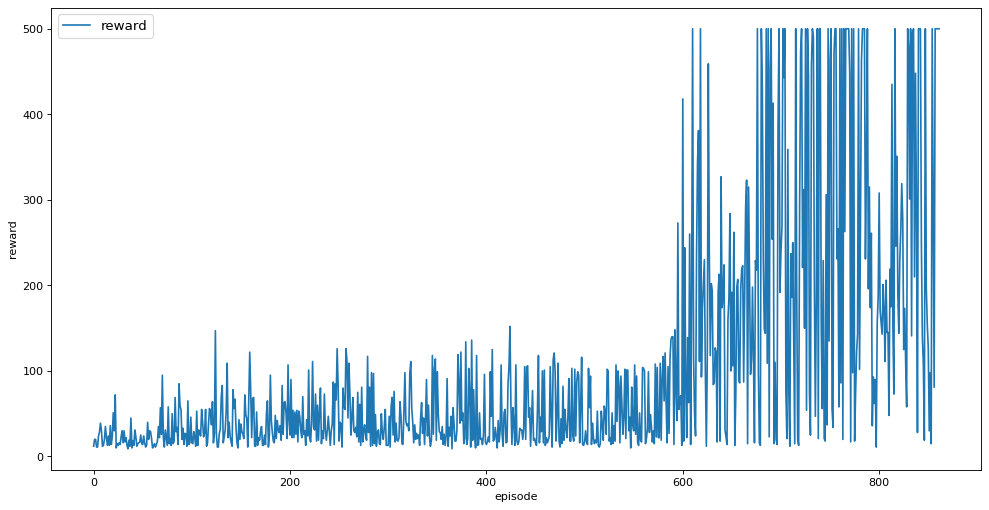

Save result/DuelingDQN/cartpole/loss_2023_07_05_01_38_10.png


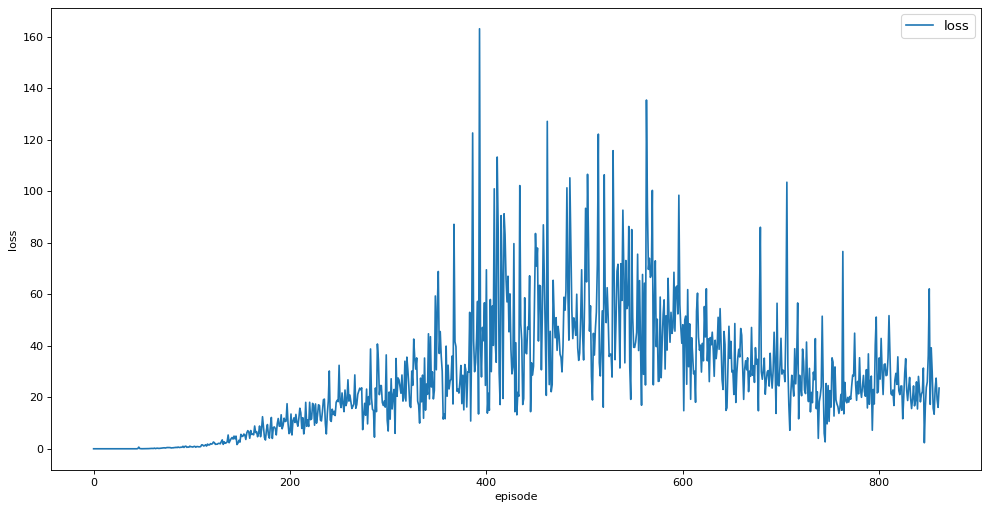

In [18]:
fig, ax = rl_util.init_2d_figure("Reward")
rl_util.plot_graph(
    ax,
    episode_returns,
    title="reward",
    ylabel="reward",
    save_dir_name=save_dir,
    is_save=True,
)
rl_util.show_figure()
fig, ax = rl_util.init_2d_figure("Loss")
rl_util.plot_graph(
    ax, episode_losses, title="loss", ylabel="loss", save_dir_name=save_dir, is_save=True
)
rl_util.show_figure()

In [1]:
env = gym.make(env_name, render_mode="human")

test_agent = DuelingDQNAgent(
    obs_space_shape=env.observation_space.shape,
    action_space_dims=env.action_space.n,
    is_atari=False,
    config=config
)

# file_name = save_dir + "CartPole-v1_mean_score.pt"
test_agent.policy_network.load_state_dict(torch.load(save_model_name))

for i_episode in range(1):
    state, _ = env.reset()
    test_reward = 0
    while True:
        env.render()
        action = test_agent.select_action(state, 0.)
        next_state, reward, terminated, truncated, _ = env.step(action)
        test_reward += reward
        state = next_state
        done = terminated or truncated
        if done:
            break
    print(f"{i_episode} episode Total Reward: {test_reward}")
env.close()

NameError: name 'gym' is not defined